In [1]:
from estimador import *
from functions import *
from filtros import *
from fit_voc import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Obtenemos el Ground Truth de SOH y ciclos de las celdas

In [2]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_SOH_25deg.csv"
gt_soh_values = pd.read_csv(gt_path)
# Obtenemos los ciclos de cada celda
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_cycles_25deg.csv"
cycle_values = pd.read_csv(path)
cycle_values

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,3361,3124,2616,6200,6199,5677,5677,5678,693,703,1170,1171


## Aplicamos el modelo de degradación a cada celda
### Definimos los modelos a utilizar

In [3]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    # Qmax=df.SoH.max(),
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=938,
    adapt_cell=True,
    degradation_percentage=0.8
)

f_30_0 = FiltrosAnidados()
f_30_0.Q_inst = param.get("Qmax")
f_30_0.fit_batt_model(param)
f_30_0.modelo_th.fit_inverse()
f_30_0.voc_thresh = 0.05
f_30_0.voc_times = 47
f_30_0.sigma_autonomia = 0.04
f_30_0.sigma_capacidad = 0.001 * 5
f_30_0.estim_kwargs = {"sigma_e": 0.00075}

if f_30_0.modelo_th.parameters["adapt_cell"]:
    f_30_0.modelo_th.adapt_degradation()
    f_30_0.modelo_th.setup_knn()
    print("celda: f_30_0 adaptada")

f_85_70 = FiltrosAnidados()
f_85_70.Q_inst = param.get("Qmax")
f_85_70.fit_batt_model(param)
f_85_70.modelo_th.fit_inverse()
f_85_70.voc_thresh = 0.05
f_85_70.voc_times = 47
f_85_70.sigma_autonomia = 0.04
f_85_70.sigma_capacidad = 0.001 * 5
f_85_70.estim_kwargs = {"sigma_e": 0.00075}

if f_85_70.modelo_th.parameters["adapt_cell"]:
    f_85_70.modelo_th.adapt_degradation()
    f_85_70.modelo_th.setup_knn()
    print("celda: f_85_70 adaptada")

f_100_85 = FiltrosAnidados()
f_100_85.Q_inst = param.get("Qmax")
f_100_85.fit_batt_model(param)
f_100_85.modelo_th.fit_inverse()
f_100_85.voc_thresh = 0.05
f_100_85.voc_times = 47
f_100_85.sigma_autonomia = 0.04
f_100_85.sigma_capacidad = 0.001 * 5
f_100_85.estim_kwargs = {"sigma_e": 0.00075}

if f_100_85.modelo_th.parameters["adapt_cell"]:
    f_100_85.modelo_th.adapt_degradation()
    f_100_85.modelo_th.setup_knn()
    print("celda: f_100_85 adaptada")

f_100_0 = FiltrosAnidados()
f_100_0.Q_inst = param.get("Qmax")
f_100_0.fit_batt_model(param)
f_100_0.modelo_th.fit_inverse()
f_100_0.voc_thresh = 0.05
f_100_0.voc_times = 47
f_100_0.sigma_autonomia = 0.04
f_100_0.sigma_capacidad = 0.001 * 5
f_100_0.estim_kwargs = {"sigma_e": 0.00075}

if f_100_0.modelo_th.parameters["adapt_cell"]:
    f_100_0.modelo_th.adapt_degradation()
    f_100_0.modelo_th.setup_knn()
    print("celda: f_100_0 adaptada")

f_100_0_ = FiltrosAnidados()
f_100_0_.Q_inst = param.get("Qmax")
f_100_0_.fit_batt_model(param)
f_100_0_.modelo_th.fit_inverse()
f_100_0_.voc_thresh = 0.05
f_100_0_.voc_times = 47
f_100_0_.sigma_autonomia = 0.04
f_100_0_.sigma_capacidad = 0.001 * 5
f_100_0_.estim_kwargs = {"sigma_e": 0.00075}

if f_100_0_.modelo_th.parameters["adapt_cell"]:
    f_100_0_.modelo_th.adapt_degradation()
    f_100_0_.modelo_th.setup_knn()
    print("celda: f_100_0_ adaptada")

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [1.00000266], '75-0': [1.0000186], '100-50': [0.99999203], '75-25': [1.00001521], '50-0': [1.00002874], '100-75': [1.00002146], '75-50': [1.00000881], '62.5-37.5': [1.0000062], '50-25': [1.00003347], '25-0': [1.00004184]}
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [1.00000266],
                      '100-50': [0.99999203],
                      '100-75': [1.00002146],
                      '25-0': [1.00004184],
                      '50-0': [1.00002874],
                      '50-25': [1.00003347],
                     

### Ejecutamos el modelo de degradación para cada celda

In [5]:
cells = ["D30_0","D85_70","D100_85","D100_0_drive","D100_0_"]
models = [f_30_0,f_85_70,f_100_85,f_100_0,f_100_0_]
SR = [[30,0],[85,70],[100,85],[100,0],[100,0]]

for model in models:
    model.Q_inst = param.get("Qmax")

cells_SOH_list = []
max_len = 0
Q_healthy = param.get("Qmax")
cell_eq_cycle = pd.DataFrame()
max_values = pd.DataFrame()

for i,cell in enumerate(cells):
    SOH_values = []
    eq_cycle_cnt = 0
    soc_inst = SR[i][0]
    soc_counting_eqcycle = [soc_inst]
    soc_acc = 0

    soc_profile = generate_soc_profile(SR[i][0],SR[i][1],cycle_values[cell].values[0])
    differences = [soc_profile[i] - soc_profile[i-1] for i in range(1, len(soc_profile))]
    for dsoc in differences:
        soc_inst += dsoc
        soc_counting_eqcycle.append(soc_inst)
        if dsoc < 0:
            soc_acc+=dsoc
        if soc_acc < -100:
            eta_k_eqcycle = models[i].get_factor(soc_counting_eqcycle,unnml=False)
            models[i].Q_inst *= eta_k_eqcycle[0]

            soc_acc = 0
            soc_counting_eqcycle = [soc_counting_eqcycle[-1]]
            eq_cycle_cnt += 1
        SOH_values.append(models[i].Q_inst / Q_healthy)
    
    max_len = len(SOH_values)
    max_values[cell] = [max_len]
    cells_SOH_list.append(SOH_values)
    cell_eq_cycle[cell] = [eq_cycle_cnt]
    eq_cycle_cnt = 0
    SOH_values = []

eta normal:  [0.99973784]  aplicado
eta normal:  [0.99974047]  aplicado
eta normal:  [0.99974092]  aplicado
eta normal:  [0.99973862]  aplicado
eta normal:  [0.99974107]  aplicado
eta normal:  [0.99973998]  aplicado
eta normal:  [0.99973935]  aplicado
eta normal:  [0.99974162]  aplicado
eta normal:  [0.99973894]  aplicado
eta normal:  [0.99974004]  aplicado
eta normal:  [0.99974147]  aplicado
eta normal:  [0.99973811]  aplicado
eta normal:  [0.99974067]  aplicado
eta normal:  [0.99974062]  aplicado
eta normal:  [0.99973887]  aplicado
eta normal:  [0.99974126]  aplicado
eta normal:  [0.99973965]  aplicado
eta normal:  [0.99973958]  aplicado
eta normal:  [0.99974178]  aplicado
eta normal:  [0.99973857]  aplicado
eta normal:  [0.99974025]  aplicado
eta normal:  [0.9997412]  aplicado
eta normal:  [0.99973836]  aplicado
eta normal:  [0.99974088]  aplicado
eta normal:  [0.99974031]  aplicado
eta normal:  [0.99973911]  aplicado
eta normal:  [0.99974144]  aplicado
eta normal:  [0.9997393]  apl

In [7]:
cell_eq_cycle

,D30_0,D85_70,D100_85,D100_0_drive,D100_0_
0,998,920,843,686,1158


### Obtenemos el df con los SOH calculados y rellenamos con nan

In [8]:
cells_SOH = pd.DataFrame()
max_length = max(len(list) for list in cells_SOH_list)

# Function to pad the list with NaN to match the maximum length
def pad_list(lst, length):
    return lst + [np.nan] * (length - len(lst))

for i,cell in enumerate(cells):
    cells_SOH[cell] = pad_list(cells_SOH_list[i], max_length)

### Adaptamos los indices del GT

In [9]:
indexes = []
indexes_df = pd.DataFrame()
for i,cell in enumerate(cells):
    count = gt_soh_values[cell].count()
    index_list = np.linspace(0, max_values[cell][0], count)
    indexes_ = [np.round(idx,0) for idx in index_list.tolist()]
    indexes.append(indexes_)

max_length = 16
for i,cell in enumerate(cells):
    indexes[i] = pad_list(indexes[i], max_length)
    indexes_df[cell] = indexes[i]
    
indexes_df

,D30_0,D85_70,D100_85,D100_0_drive,D100_0_
0,0.0,0.0,0.0,0.0,0.0
1,8015.0,8265.0,8257.0,7777.0,7878.0
2,16029.0,16530.0,16515.0,15554.0,15756.0
3,24044.0,24796.0,24772.0,23331.0,23634.0
4,32058.0,33061.0,33029.0,31108.0,31512.0
5,40073.0,41326.0,41287.0,38884.0,39390.0
6,48088.0,49592.0,49544.0,46661.0,47268.0
7,56102.0,57857.0,57802.0,54438.0,55146.0
8,64117.0,66122.0,66059.0,62215.0,63023.0
9,72132.0,74387.0,74316.0,69992.0,70901.0


### Graficamos los valores

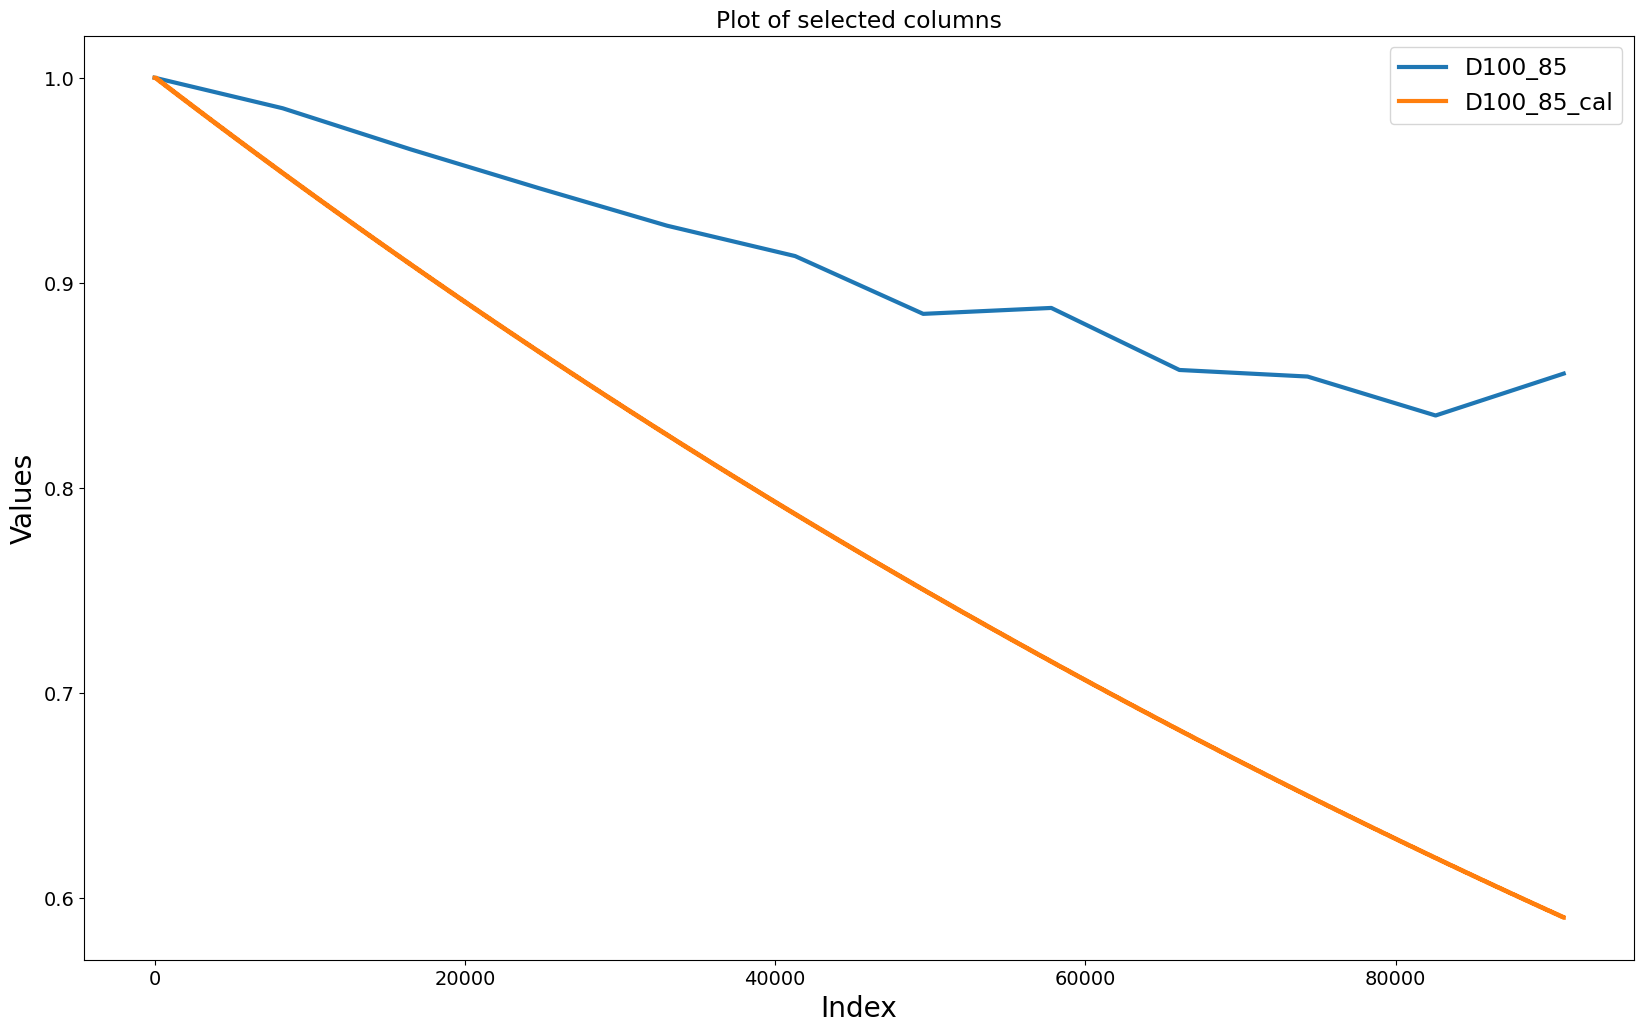

In [10]:
# selected_columns = ["D30_0","D85_70","D100_85","D100_0_drive","D100_0_"]
selected_columns = ["D100_85"]
plt.figure(figsize=(20, 12))

for i, cell in enumerate(selected_columns):
    plt.plot(indexes_df[cell], gt_soh_values[cell], label=cell)
    plt.plot(cells_SOH[cell].values, label=cell+'_cal')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of selected columns')
plt.legend()
plt.show()